In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj
from io import StringIO
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics, svm
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

import imodels
import sys
sys.path.append('../../../../')
from rulevetting.api import validation
from rulevetting.projects.tbi_pecarn.dataset import Dataset
from rulevetting.projects.tbi_pecarn.graph import barplot

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output
data_path = '../../../../data/' # path to raw csv - change to processed...

# default plotting properties - has to be an easier way then doing this every notebook
TINY_SIZE = 10
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
MARKER_SIZE = 6
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width

mpl.rcParams["figure.dpi"] = 180

# Height and width per row and column of subplots
FIG_HEIGHT = 20
FIG_WIDTH = 18
fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("colorblind")

/Users/sahilsaxena/rule-env/lib/python3.9/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [ ]:
def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

def predict_stats(y_true, y_pred_prob, verbose = True) :
    '''
    Choose the threshold for probability using Youden's J-statistic (tpr - fpr),
    then prints AUC, accuracy, balanced accuracy, sensitivity, and specificity
    
    input
    ------
    y_true      : true outcome values
    y_pred_prob : predicted probability of being positive (tbi)
    verbose     : Print the statistics or not
    
    output
    ------
    Prints (if verbose = True) and returns the dictionary containing statistics
    (AUC, accuracy, balanced accuracy, sensitivity, specificity)
    '''
    
    from sklearn.metrics import confusion_matrix
    
    fpr, tpr, thresholds = roc_curve(y_tune, y_pred_prob)
    J = tpr - fpr
    thresh = thresholds[np.argmax(J)]  
    y_tune_pred = y_pred_prob > thresh

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_tune_pred)
    
    # Calculating statistics
    n = sum(sum(cm))
    auc = roc_auc_score(y_tune, y_pred_prob)
    acc = (cm[0,0] + cm[1,1]) / n
    sens = cm[0,0] / (cm[0,0] + cm[0,1])
    spec = cm[1,1] / (cm[1,0] + cm[1,1])
    balacc = (sens + spec) / 2
    
    if verbose :
        print('Confusion Matrix : \n', cm)
        print(f'Prob. threshold : {thresh:.5f}')
        print(f'AUC             : {auc:.3f}')  
        print(f'Accuracy        : {acc:.3f}')
        print(f'Sensitivity     : {sens:.3f}')
        print(f'Specificity     : {spec:.3f}')
        print(f'Balanced Acc.   : {balacc:.3f}')

    return {'AUC' : auc, 'Accuracy' : acc, 'Balanced Accuracy' : balacc, "Sensitivity" : sens, "Specificity" : spec}

In [3]:
##################
# DATA SELECTION #
##################

simple = False    # 43 Columns or 118 Columns
young = True     # Include Age < 2                  (6432 + 2144 + 2145 samples)
old = True        # Include Age > 2                  (19025 + 6342 + 6432 samples)
    
df_train, df_tune, df_test = Dataset().get_data(simple=simple, young=young, old=old)
outcome_def = 'outcome'
X_train = df_train.drop(columns=outcome_def)
y_train = df_train[outcome_def].values
X_tune = df_tune.drop(columns=outcome_def)
y_tune = df_tune[outcome_def].values

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


In [4]:
# SANITY CHECK
train_positive_prop = sum(y_train == 1) / len(y_train)
tune_positive_prop = sum(y_tune == 1) / len(y_tune)

train_positive_prop, tune_positive_prop

(0.009113048943357687, 0.009898656610888523)

Using an SVM is an interpretable way to model our data and consequently, learn more about it. 

# Linear SVM, with large C, to dermine linear separability of regular (all ages)

In the following SVM formulation, 
\begin{align}\begin{aligned}\min_ {w, b, \zeta} \frac{1}{2} w^T w + C \sum_{i=1}^{n} \zeta_i\\\begin{split}\textrm {subject to } & y_i (w^T \phi (x_i) + b) \geq 1 - \zeta_i,\\
& \zeta_i \geq 0, i=1, ..., n\end{split}\end{aligned}\end{align}
the C term serves to control the strength of a penalty. If we make C very high, we are forcing the optimization process to make no error in classification in order to minimize the loss function. While overfitting the data, if it can be done with a linear hyperplane, then we know the data is iinearly separable.

In [6]:
svm_lin_init = svm.LinearSVC(C = 2**32).fit(X_train, y_train)
print("Train ACC:", svm_lin_init.score(X_train, y_train))
print("Tune ACC:", svm_lin_init.score(X_tune, y_tune))

Train ACC: 0.9908869510566423
Tune ACC: 0.9901013433891115


/Users/sahilsaxena/rule-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


With a train accuracy of 99.1% and a tune accuracy of 99.0%, we can say that the data, in its 118 dimension space, is very close to being linearly separable. This means that a linear hyperplane comes very close to perfectly splitting the data, but about 1% of the data is misclassified (falls on the wrong side of the hyperplane). 

We can run SVM on a dimension reduced dataset to visualize the hyperplane. The support vectors, the data points that influence the decision boundary the most, will be near the hyperplane and can be further analyzed to see if these data points are "statistical anamolies" or true to the distribution.

# PCA on the simple dataset

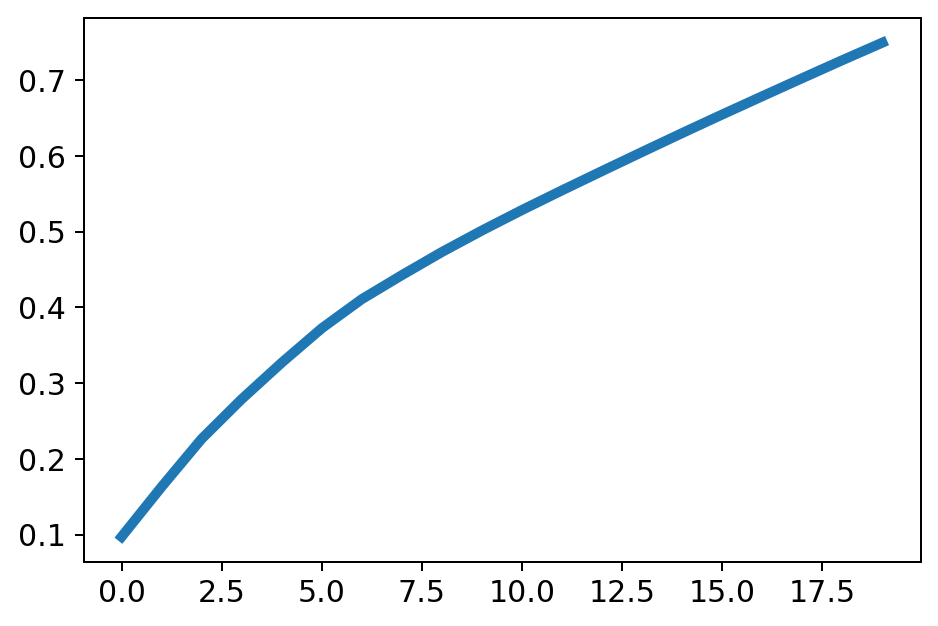

In [6]:
df_train, df_tune, df_test = Dataset().get_data(simple=True, young=True, old=True)
outcome_def = 'outcome'

data4_scaled = StandardScaler().fit_transform(df_train)

# Conducting PCA 
pca = PCA().fit(data4_scaled) 
explained_variance = np.copy(pca.explained_variance_ratio_)
explained_variance_sum = explained_variance

# Variance explained
for i in range(1, len(explained_variance_sum)) :
    explained_variance_sum[i] += explained_variance_sum[i-1] 

# Scree Plot
plt.plot(explained_variance_sum[0:200][0:20])

# PC Scores
pc_score = pca.transform(data4_scaled)

In [50]:
# Fit the data with an svm
svc = svm.LinearSVC()
svc.fit(X_train, y_train)
z = lambda x,y: (-svc.intercept_[0]-svc.coef_[0][0]*x-svc.coef_[0][1]*y) / svc.coef_[0][2]
tmp = np.linspace(-10,10,51)
x,y = np.meshgrid(tmp,tmp)

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


/Users/sahilsaxena/rule-env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [4]:
from rulevetting.projects.tbi_pecarn.eval_models import *

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5521/5521 [00:15<00:00, 358.82it/s]


Confusion Matrix : 
 [[  221    11]
 [11811 13415]]
Prob. threshold : 0.00289
AUC             : 0.906
Accuracy        : 0.536
Sensitivity     : 0.953
Specificity     : 0.532
Balanced Acc.   : 0.742
NPV             : 0.999


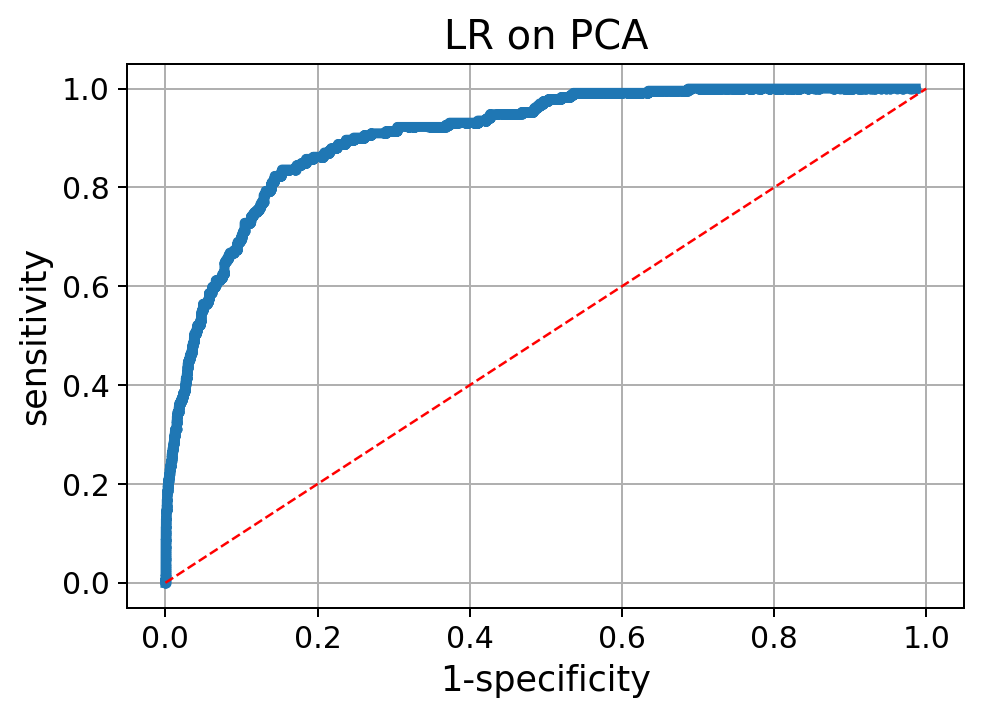

In [10]:
# Fit the data with log reg l1
X_train = pc_score[:,0:3]
y_train = df_train[outcome_def].values
lr, stats = fit_eval_lr(X_train, y_train, X_train, y_train, 'LR on PCA')

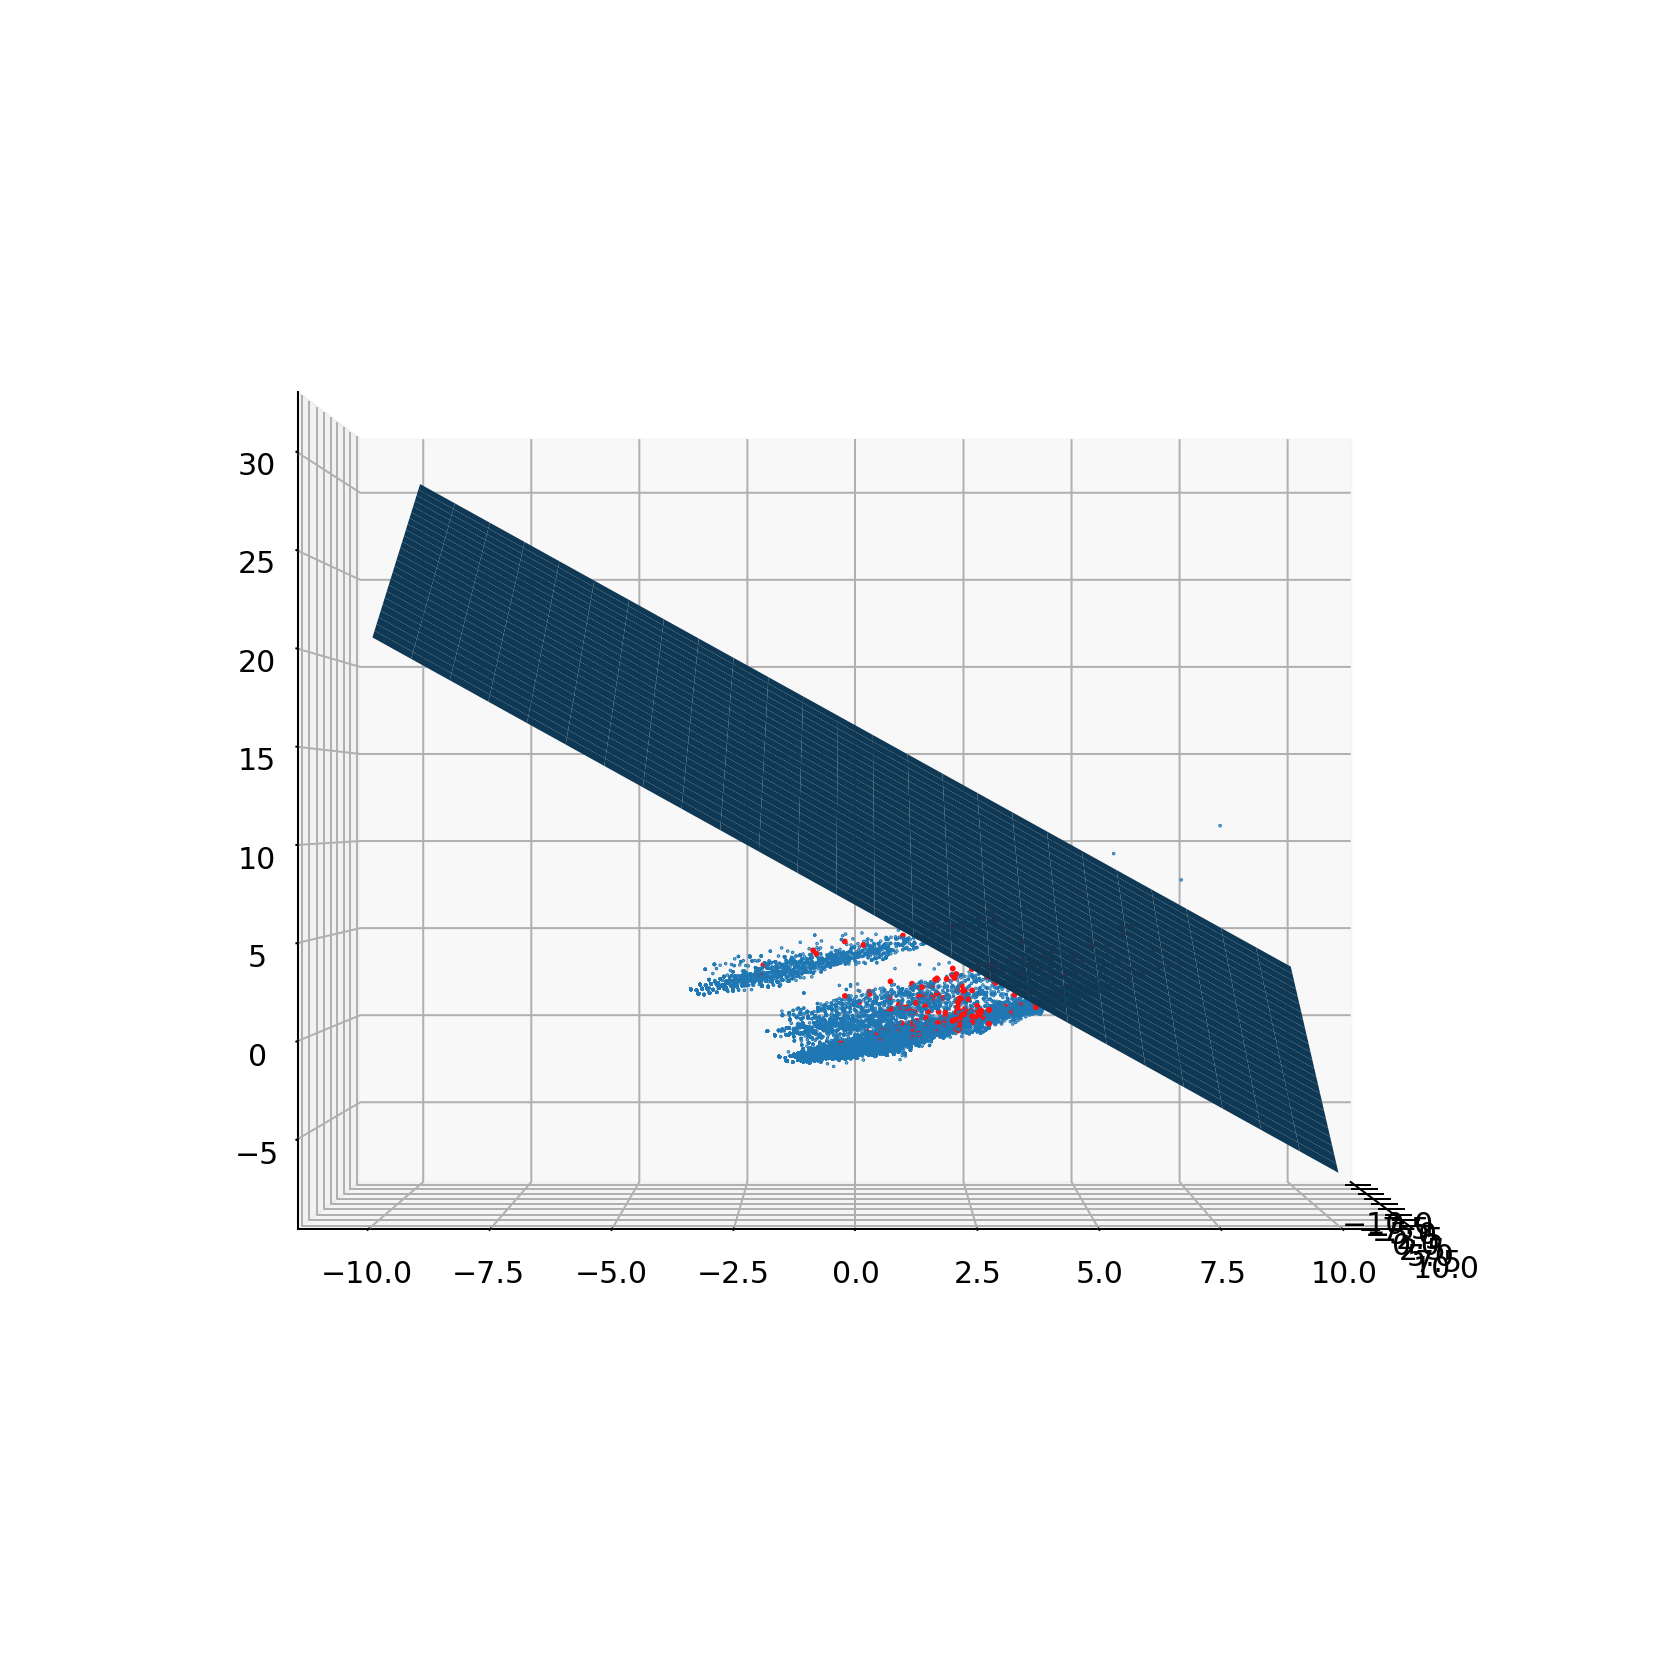

In [17]:
z = lambda x,y: (-lr.intercept_[0]-lr.coef_[0][0]*x-lr.coef_[0][1]*y) / lr.coef_[0][2]
tmp = np.linspace(-10,10,51)
x,y = np.meshgrid(tmp,tmp)
posint_col = np.where(df_train['outcome'] == 1, '#ff0f0e', '#1f77b4')
posint_sz = np.where(df_train['outcome'] == 1, 7, 0.7)
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z(x,y))
ax.scatter3D(pc_score[:,0], pc_score[:,1], pc_score[:,2], c = posint_col, s = posint_sz, alpha = 1, marker = '.')
ax.view_init(0, 0)
plt.show()

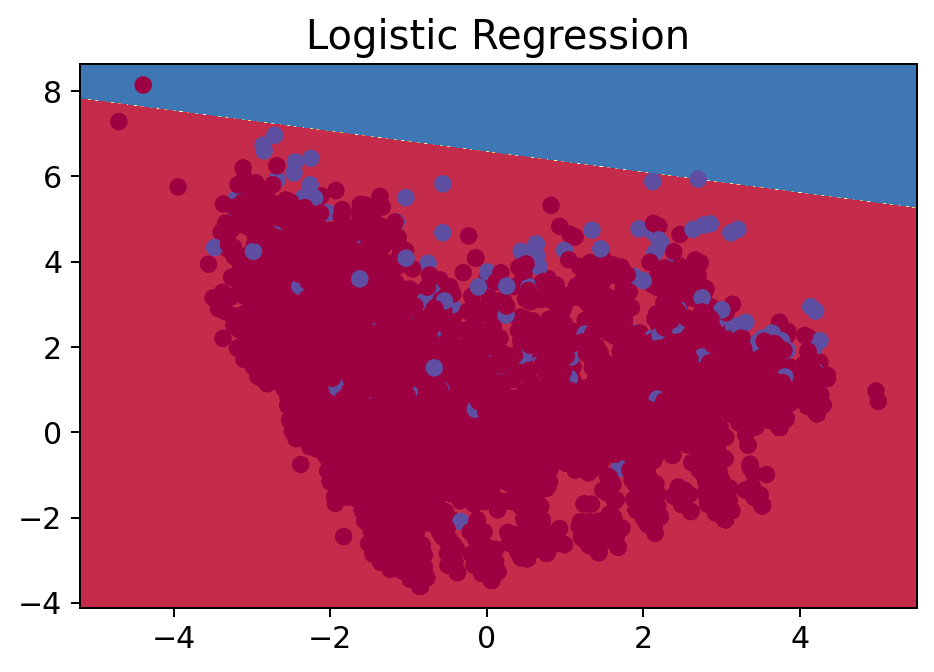

In [9]:
# 2D
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)
    
plot_decision_boundary(lambda x: lr.predict(x))
plt.title("Logistic Regression on PCA")
plt.show()

Based on the SVM decision boundary in the 3 PC dimension space, it seems like the SVM does not do a good job of splitting the data. In fact the high accuracy (in earlier parts) probably comes from the fact that 99% of our data is negative outcome. So the hyperplane is placed around the data that the entire dataset is on one side of it; this way 99% of the data points will still be correctly classified. However the other side of the hyperplane (signifying the model's predicted positive outcomes) is completely empty. 

In [7]:
# constants
lamb_vec = [2**(-6), 2**(-5), 2**(-4), 2**(-3), 2**(-2), 2**(2), 2**(4), 2**(6)]
outcome_def = 'outcome'

def run_svm(kernel, simple, young, old):    
    # get data
    print("Getting dataset")
    df_train, df_tune, df_test = Dataset().get_data(simple=simple, young=young, old=old)
    X_train = df_train.drop(columns=outcome_def)
    y_train = df_train[outcome_def].values
    X_tune = df_tune.drop(columns=outcome_def)
    y_tune = df_tune[outcome_def].values
    
    # run validation
    roc_tune_svm = []
    acc_tune_svm = []
    for c in lamb_vec:
        svm_v = svm.SVC(kernel = kernel, C = c, probability=True).fit(X_train, y_train)
        roc_tune_svm.append(roc_auc_score(y_tune, svm_v.predict_proba(X_tune)[:, 1]))
        acc_tune_svm.append(svm_v.score(X_tune, y_tune))
    print("\nValidation AUC:", np.around(roc_tune_svm, 5))
    print("Validation ACC:", np.around(acc_tune_svm, 5))
    
    best_lamb = lamb_vec[np.argmax(np.array(roc_tune_svm))]
    print("\nOptimal C:", np.around(best_lamb, 5))
    
    # choose final model
    svm_final = svm.SVC(kernel = kernel, C = best_lamb, probability=True).fit(X_train, y_train)
    print("\nTrain AUC:", roc_auc_score(y_train, svm_final.predict_proba(X_train)[:, 1]))
    print("Train ACC:", svm_final.score(X_train, y_train))
    print("Tune AUC:", roc_auc_score(y_tune, svm_final.predict_proba(X_tune)[:, 1])) 
    print("Tune ACC:", svm_final.score(X_tune, y_tune))

    # Plot the result for the tune set
    validation.all_stats_curve(y_tune, svm_final.predict_proba(X_tune)[:, 1], plot = True)
    plt.show()
    
    # full stats summary
    print()
    predict_stats(y_tune, svm_final.predict_proba(X_tune)[:, 1])
    
    # feature importance
    if kernel == 'linear':
        print()
        pd.Series(abs(svm_final.coef_[0]), index=X_train.columns).nlargest(12).sort_values(ascending=True).plot(
            kind='barh', label = 'index', colormap = 'Paired', title = 'Top 12 Feature Coefficients'
        )

# SVM, with Linear kernal, on regular (young only)

Getting dataset
kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}

Validation AUC: [0.52102 0.76579 0.72887 0.78638 0.75184 0.54222 0.6376  0.64926]
Validation ACC: [0.9901 0.9901 0.9901 0.9901 0.9901 0.9901 0.9901 0.9901]

Optimal C: 0.125

Train AUC: 0.7876184635720671
Train ACC: 0.9908869510566423
Tune AUC: 0.7863844776187076
Tune ACC: 0.9901013433891115


100%|██████████████████████████████████████| 5468/5468 [00:06<00:00, 900.26it/s]


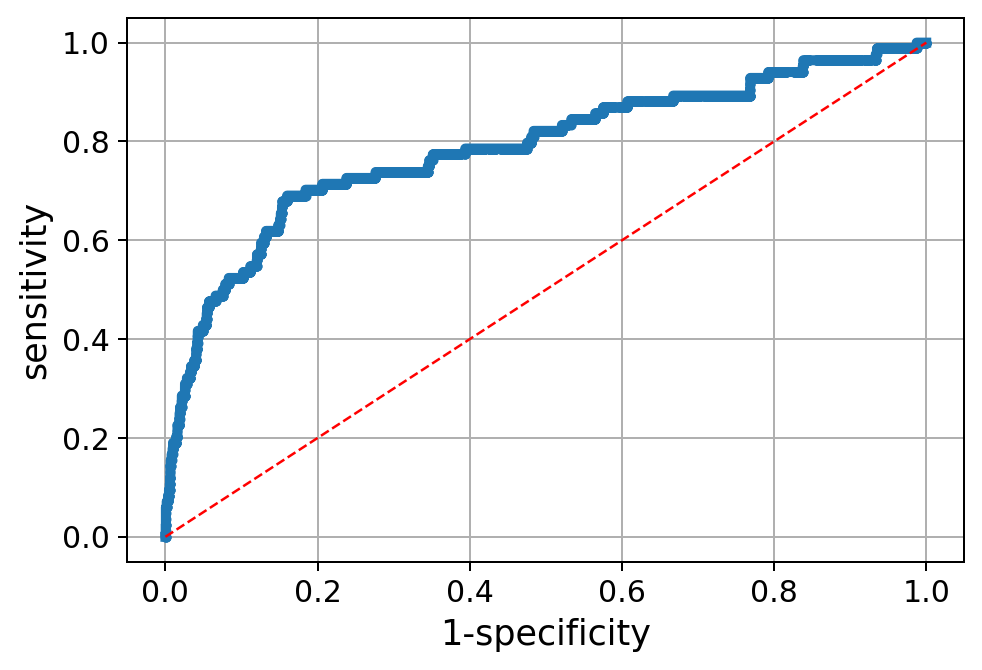


Confusion Matrix : 
 [[7058 1344]
 [  27   57]]
Prob. threshold : 0.01348
AUC             : 0.786
Accuracy        : 0.838
Sensitivity     : 0.840
Specificity     : 0.679
Balanced Acc.   : 0.759



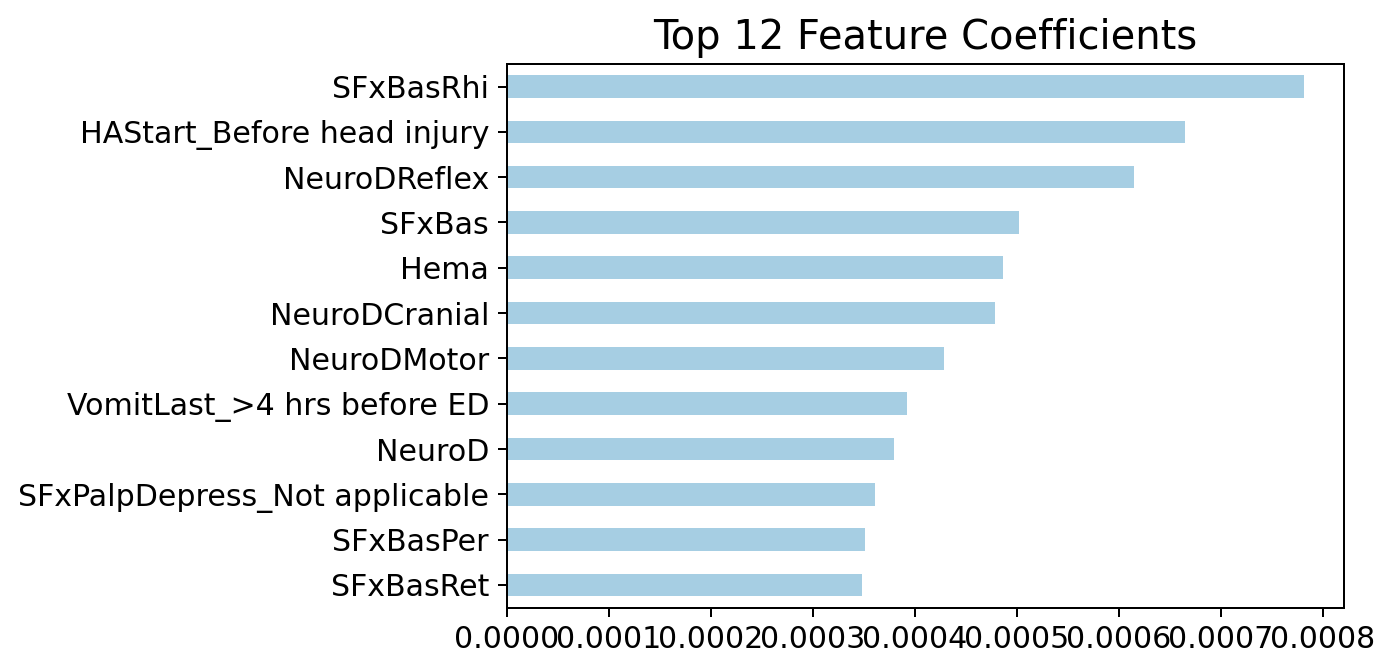

In [8]:
run_svm('linear', False, True, False)

# SVM, with Linear kernal, on regular (old only)

Getting dataset
kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}

Validation AUC: [0.52102 0.76579 0.72887 0.78638 0.75184 0.54222 0.6376  0.64926]
Validation ACC: [0.9901 0.9901 0.9901 0.9901 0.9901 0.9901 0.9901 0.9901]

Optimal C: 0.125

Train AUC: 0.7876184635720671
Train ACC: 0.9908869510566423
Tune AUC: 0.7863844776187076
Tune ACC: 0.9901013433891115


100%|██████████████████████████████████████| 5468/5468 [00:06<00:00, 854.32it/s]


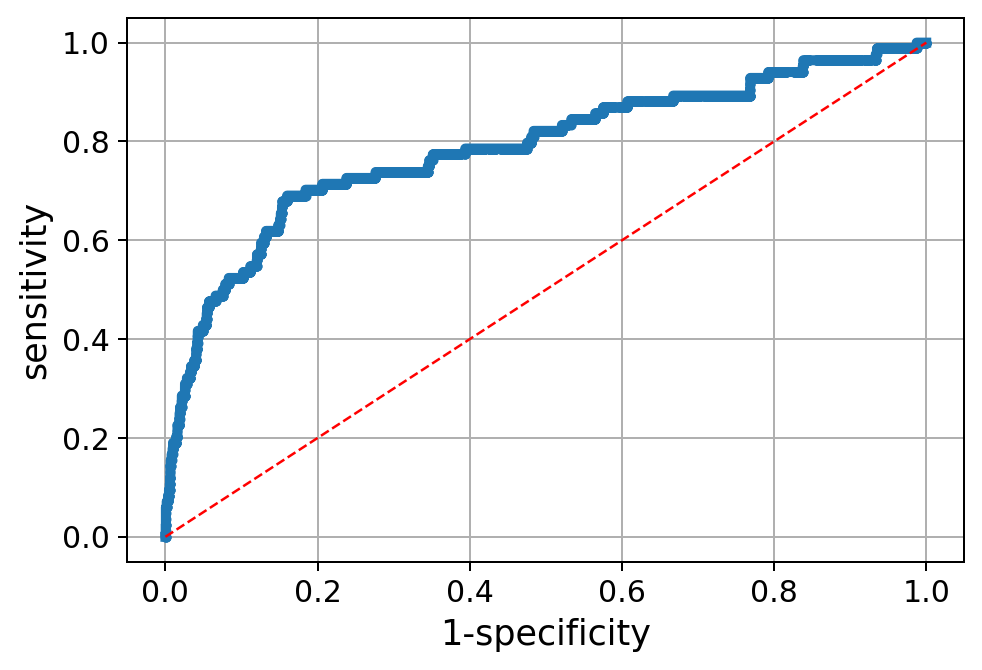


Confusion Matrix : 
 [[7058 1344]
 [  27   57]]
Prob. threshold : 0.01348
AUC             : 0.786
Accuracy        : 0.838
Sensitivity     : 0.840
Specificity     : 0.679
Balanced Acc.   : 0.759



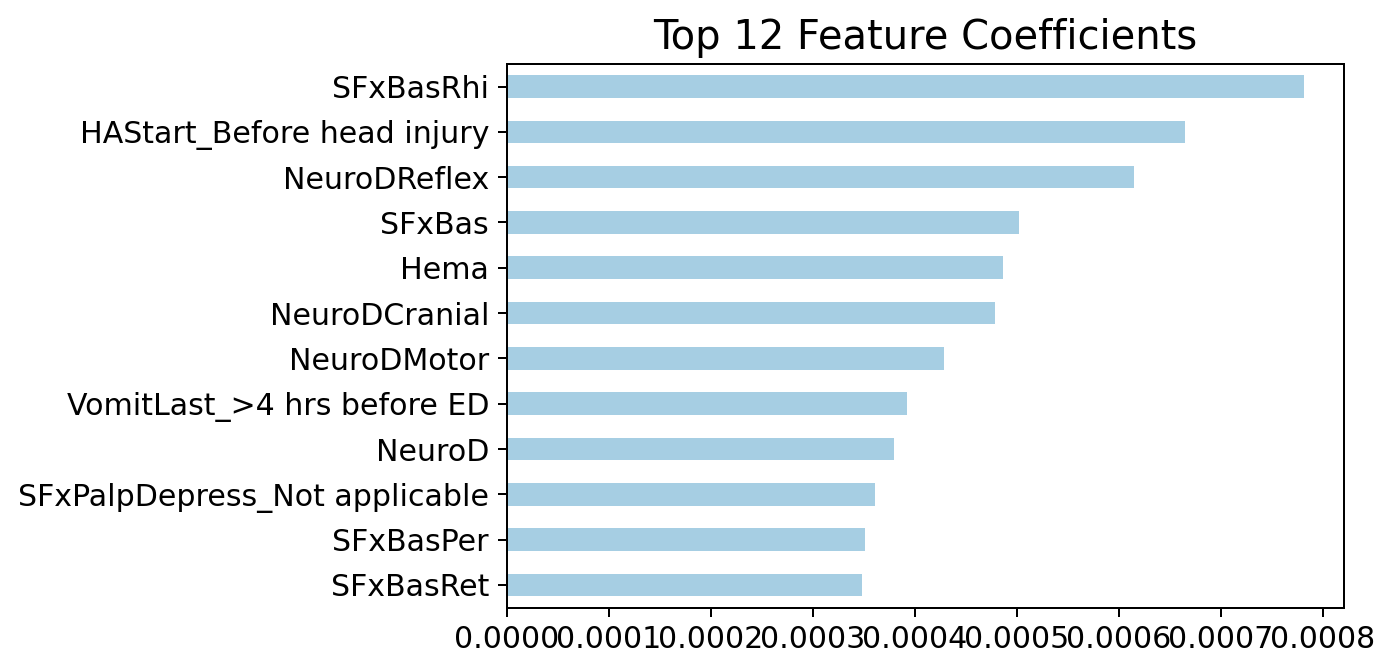

In [9]:
run_svm('linear', False, False, True)

# SVM, with Linear kernal, on simple (all ages)

In [46]:
lamb_vec = [2**(-6), 2**(-5), 2**(-4), 2**(-3), 2**(-2), 2**(2), 2**(4), 2**(6)]
roc_tune_svm_lin = []
acc_tune_svm_lin = []
i = 1
for c in lamb_vec:
    svm_v = svm.SVC(C = c, kernel = 'linear', probability=True).fit(X_train, y_train)
    roc_tune_svm_lin.append(roc_auc_score(y_tune, svm_v.predict_proba(X_tune)[:, 1]))
    acc_tune_svm_lin.append(svm_v.score(X_tune, y_tune))
    print(f"{i} down, {len(lamb_vec) - i} to go")
    i += 1

print("Validation AUC:", np.around(roc_tune_svm_lin, 5))
print("Validation ACC:", np.around(acc_tune_svm_lin, 5))

1 down, 7 to go
2 down, 6 to go
3 down, 5 to go
4 down, 4 to go
5 down, 3 to go
6 down, 2 to go
7 down, 1 to go
8 down, 0 to go
Validation AUC: [0.50244 0.5321  0.66284 0.40661 0.72326 0.62543 0.3924  0.34005]
Validation ACC: [0.9901 0.9901 0.9901 0.9901 0.9901 0.9901 0.9901 0.9901]


In [47]:
best_lamb_lin = lamb_vec[np.argmax(np.array(roc_tune_svm_lin))]
print("Optimal C:", np.around(best_lamb_lin, 5))

Optimal C: 0.25


Train Accuracy: 0.9908869510566423
Train AUC: 0.7748634242995049
Tune AUC: 0.7232546672560956
Tune ACC: 0.9901013433891115


100%|██████████████████████████████████████| 3342/3342 [00:04<00:00, 829.57it/s]


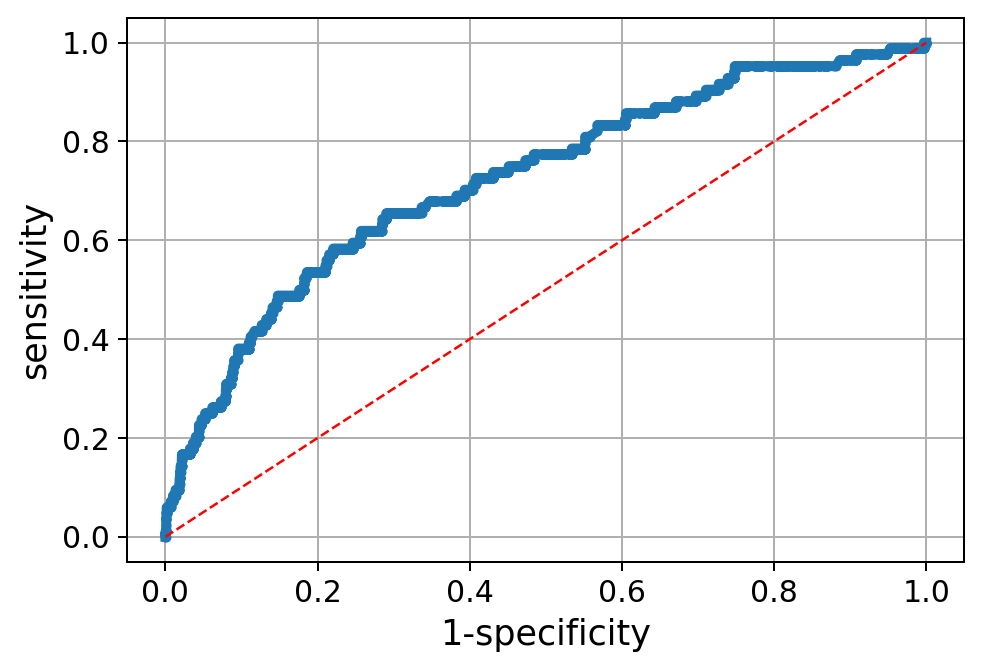

In [54]:
svm_lin_final = svm.SVC(C = best_lamb_lin, kernel = 'linear', probability=True).fit(X_train, y_train)
print("Train Accuracy:", svm_lin_final.score(X_train, y_train))
print("Train AUC:", roc_auc_score(y_train, svm_lin_final.predict_proba(X_train)[:, 1]))
print("Tune AUC:", roc_auc_score(y_tune, svm_lin_final.predict_proba(X_tune)[:, 1])) 
print("Tune ACC:", svm_lin_final.score(X_tune, y_tune))

# Plot the result for the tune set
validation.all_stats_curve(y_tune, svm_lin_final.predict_proba(X_tune)[:, 1], plot = True)
plt.show()

In [51]:
predict_stats(y_tune, svm_lin_final.predict_proba(X_tune)[:, 1])

Confusion Matrix : 
 [[5962 2440]
 [  30   54]]
Prob. threshold : 0.00848
AUC             : 0.723
Accuracy        : 0.709
Sensitivity     : 0.710
Specificity     : 0.643
Balanced Acc.   : 0.676


{'AUC': 0.7232575010485032,
 'Accuracy': 0.7089323591798256,
 'Balanced Accuracy': 0.6762250484578503,
 'Sensitivity': 0.7095929540585575,
 'Specificity': 0.6428571428571429}

<AxesSubplot:title={'center':'Top 12 Feature Coefficients'}>

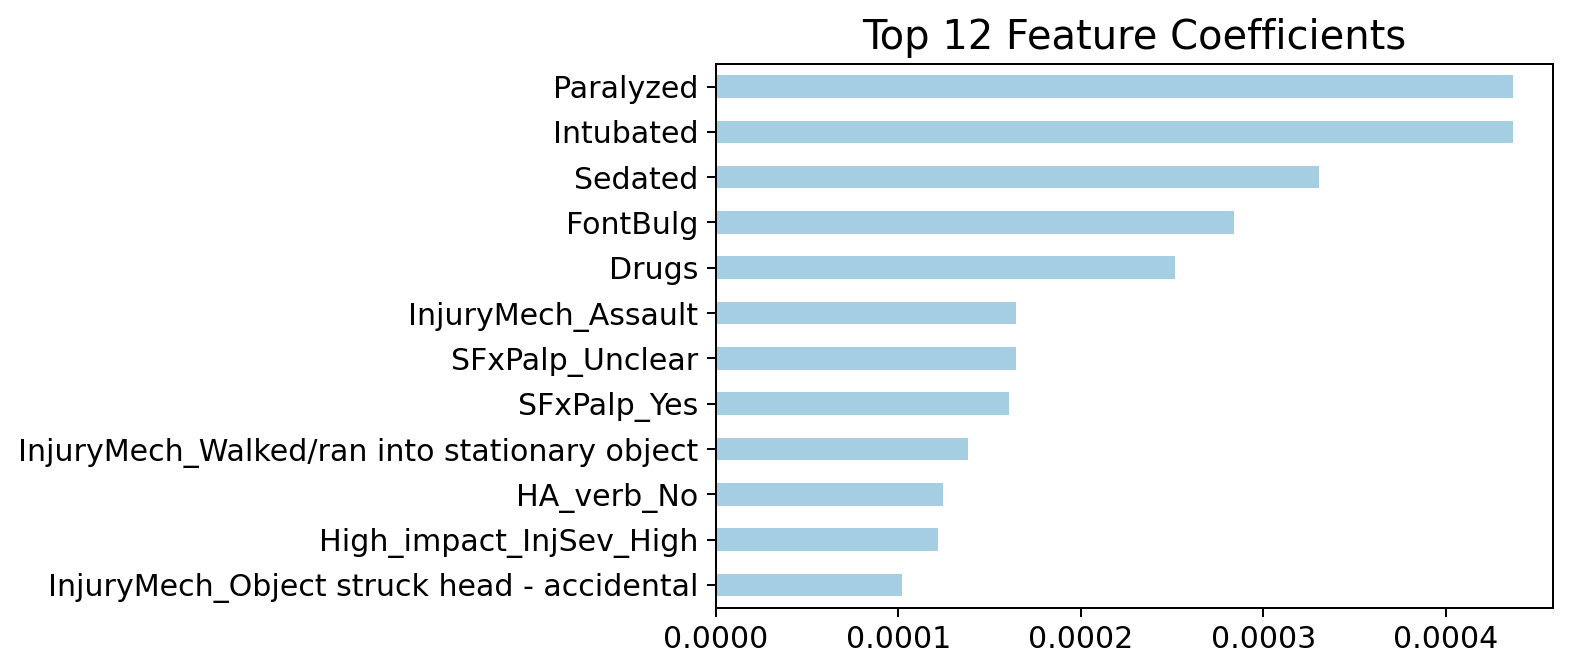

In [91]:
pd.Series(abs(svm_lin_final.coef_[0]), index=X_train.columns).nlargest(12).sort_values(ascending=True).plot(
    kind='barh', label = 'index', colormap = 'Paired', title = 'Top 12 Feature Coefficients'
)

# SVM, with Linear kernal, on regular (all ages)

In [ ]:
run_svm('linear', False, True, True)

# SVM, with Linear kernal, on simple (old only)

In [ ]:
run_svm('linear', True, False, True)

# SVM, with Linear kernal, on simple (young only)

In [ ]:
run_svm('linear', True, True, False)